# Classificação desbalanceada (Escolha do valor de limiar para classicação e cálculo das métricas ROC e AUC)

Esse notebook é uma tradução e adaptação do exemplo apresentado [no site do Keras](https://keras.io/examples/structured_data/imbalanced_classification/), criado por [fchollet](https://twitter.com/fchollet), e que utiliza essa base de dados do Kaggle [aqui](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud).


## Introdução

Este exemplo mostra como treinar um modelo classificador quando os dados são altamente desbalanceados. O objetivo é treinar uma rede neural capaz de identificar operações financeiras fraudulentas.

## Vetorizando os dados CSV

In [1]:
import csv
import numpy as np

# Os dados reais contendo operações financeiras pode ser obtido em https://www.kaggle.com/mlg-ulb/creditcardfraud/
fname = "creditcard.csv"

todas_caracteristicas = []
todos_rotulos         = []
with open(fname) as f:
    for i, line in enumerate(f):
        if i == 0: # primeira linha da tabela: cabeçalho
            print("CABECALHO:", line.strip())
            continue  # pula cabeçalho da tabela
        fields = line.strip().split(",")
        todas_caracteristicas.append([float(v.replace('"', "")) for v in fields[:-1]])
        todos_rotulos.append([int(fields[-1].replace('"', ""))])
        if i == 1:
            print("CARACTERISTICAS:", todas_caracteristicas[-1])

caracteristicas = np.array(todas_caracteristicas, dtype="float32")
valores_alvo    = np.array(todos_rotulos, dtype="uint8")
print("caracteristicas.shape:", caracteristicas.shape)
print("valores_alvo.shape:", valores_alvo.shape)

CABECALHO: "Time","V1","V2","V3","V4","V5","V6","V7","V8","V9","V10","V11","V12","V13","V14","V15","V16","V17","V18","V19","V20","V21","V22","V23","V24","V25","V26","V27","V28","Amount","Class"
CARACTERISTICAS: [0.0, -1.3598071336738, -0.0727811733098497, 2.53634673796914, 1.37815522427443, -0.338320769942518, 0.462387777762292, 0.239598554061257, 0.0986979012610507, 0.363786969611213, 0.0907941719789316, -0.551599533260813, -0.617800855762348, -0.991389847235408, -0.311169353699879, 1.46817697209427, -0.470400525259478, 0.207971241929242, 0.0257905801985591, 0.403992960255733, 0.251412098239705, -0.018306777944153, 0.277837575558899, -0.110473910188767, 0.0669280749146731, 0.128539358273528, -0.189114843888824, 0.133558376740387, -0.0210530534538215, 149.62]
caracteristicas.shape: (284807, 30)
valores_alvo.shape: (284807, 1)


## Preparando os dados

In [2]:
num_amostras_validacao = int(len(caracteristicas) * 0.2) # deixaremos 20% dos dados para validação
X_trein = caracteristicas[:-num_amostras_validacao]
y_trein = valores_alvo[:-num_amostras_validacao]
X_val   = caracteristicas[-num_amostras_validacao:]
y_val   = valores_alvo[-num_amostras_validacao:]

print("Número de amostras de treinamento:", len(X_trein))
print("Número de amostras de validação:", len(X_val))

Número de amostras de treinamento: 227846
Número de amostras de validação: 56961


## Análise do desbalanceamento nos rótulos e atribuição de pesos diferentes

In [3]:
qtdade_amostras_cada_classe = np.bincount(y_trein[:, 0]) # função do numpy que conta a quantidade de amostras para cada classe
print(qtdade_amostras_cada_classe)
print(
    "Número de amostras positivas no conjunto de dados: {} ({:.2f}% do total)".format(
        qtdade_amostras_cada_classe[1], 100 * float(qtdade_amostras_cada_classe[1]) / len(y_trein)
    )
)

peso_classe_0 = 1.0 / qtdade_amostras_cada_classe[0]
peso_classe_1 = 1.0 / qtdade_amostras_cada_classe[1]

print("Peso para classe 0:", peso_classe_0 )
print("Peso para classe 1:", peso_classe_1 )

pesos_classes = {0: peso_classe_0, 1: peso_classe_1} # cria um dicionário com o peso de cada classe

[227429    417]
Número de amostras positivas no conjunto de dados: 417 (0.18% do total)
Peso para classe 0: 4.396976638863118e-06
Peso para classe 1: 0.002398081534772182


## Normalizando os dados usando média e desvio padrão

In [4]:
media    = np.mean(X_trein, axis=0)
X_trein -= media
X_val   -= media
desvio   = np.std(X_trein, axis=0)
X_trein /= desvio
X_val   /= desvio

## Criando uma rede neural para classificação binária

In [5]:
import keras

modelo = keras.Sequential(
    [
        keras.Input(shape=X_trein.shape[1:]),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)
modelo.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │           7,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 139,777 (546.00 KB)

 Trainable params: 139,777 (546.00 KB)

 Non-trainable params: 0 (0.00 B)

## Treinando o modelo levando em conta o desbalaceamento entre as classes

In [6]:
modelo.compile(optimizer=keras.optimizers.Adam(1e-2), loss="binary_crossentropy")

modelo.fit(
    X_trein,
    y_trein,
    batch_size=2048, # define a quantidade de amostras de cada "mini-lote" (se comentarmos essa linha, será usado o padrão de 32 amostras por mini-lote)
    epochs=30,
    class_weight=pesos_classes,
)

Epoch 1/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 3.0200e-06
Epoch 2/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1309e-06
Epoch 3/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.4872e-07
Epoch 4/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.9057e-07
Epoch 5/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.2911e-07
Epoch 6/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.2347e-07
Epoch 7/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3242e-06
Epoch 8/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5965e-07
Epoch 9/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0670e-06
Epoch 10/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3667e-06
Epoch 11/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.7535e-07
Epoch 12/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0027e-07
Epoch 13/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.2586e-07
Epoch 14/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3486e-07


In [7]:
probabilidades = modelo.predict(X_val) # cálculo da saída da rede neural para as transações de validação

print(probabilidades.shape) # verificando o shape das probabilidades

print(probabilidades[:10])

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
(56961, 1)
[[5.9747437e-21]
 [3.4183676e-17]
 [1.3701606e-19]
 [2.5090703e-05]
 [4.2516494e-04]
 [2.5588834e-08]
 [2.9230847e-07]
 [2.8650991e-26]
 [2.3584511e-05]
 [3.3014244e-17]]


In [8]:
valor_limiar = 0.5

y_val_est = (probabilidades >= valor_limiar).astype(int)

print(y_val_est.shape)
print(y_val_est[:10])

(56961, 1)
[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]


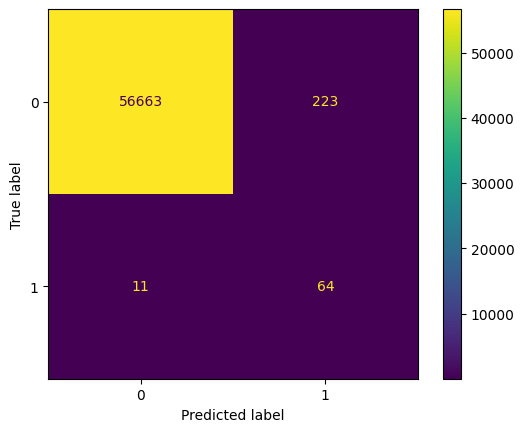

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_val, y_val_est) # cm = confusion matrix = matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()


A partir da matriz de confusão, gerada para as transações de validação, podemos perceber que (os valores abaixo podem variar ligeiramente devido à inicialização aleatória dos pesos da rede neural):

- 56961 transações de validação foram avalidadas pela rede neural
- 66 transações foram corretamente identificadas como fraudulentas
- 8 transações fraudulentas não foram detectadas
- Infelizmente, 441 transações não fraudulentas foram incorretamente classificadas como fraudulentas.


Abaixo iremos construir uma função que permite calcular a matriz de confusão e suas métricas para diferentes valores de limiar

In [10]:
def calcula_metricas(probabilidades, valor_limiar=0.5):

  y_val_est = (probabilidades >= valor_limiar).astype(int)

  cm = confusion_matrix(y_val, y_val_est) # cm = confusion matrix = matriz de confusão

  # calculando métricas relativas à matriz de confusão

  # faremos os cálculos abaixo levando em conta apenas a classe y=1 como sendo a classe "positiva" (classe de referência)
  # Note que a posição dos elementos na matriz de confusão obtida pela função "confusion_matrix" do sk learn é diferente daquela apresentada nos slides da aula.
  vp = cm[1,1] # verdadeiros positivos
  vn = cm[0,0] # verdadeiros negativos
  fp = cm[0,1] # falsos positivos
  fn = cm[1,0] # falsos negativos

  precisao  = vp / (vp + fp)
  revocacao = vp / (vp + fn)
  f1_score  = 2*precisao*revocacao / (precisao + revocacao)
  taxa_VP   = revocacao
  taxa_FP   = fp / (fp + vn)

  return precisao, revocacao, f1_score, taxa_VP, taxa_FP

In [11]:
valor_limiar = 0.5

precisao, revocacao, f1_score, taxa_VP, taxa_FP = calcula_metricas(probabilidades, valor_limiar)

print("precisão: ", precisao)

print("recall: ", revocacao)

print("F1 score: ", f1_score)

print("taxa de VP: ", taxa_VP)

print("taxa de FP: ", taxa_FP)

precisão:  0.2229965156794425
recall:  0.8533333333333334
F1 score:  0.35359116022099446
taxa de VP:  0.8533333333333334
taxa de FP:  0.003920120943641669


Note que é possível rodar a célula acima para diversos valores de limiar.

A célula abaixo faz isso sistematicamente.

In [12]:
passo = 0.02 # define o passo de incremento do valor de limiar
valores_limiar = np.arange(0, 1+passo, passo) # define valores de limiar de 0 a 1 crescendo no passo pré-estabelecido
taxas_VP = []
taxas_FP = []

linhas = []

for valor_limiar in valores_limiar:
  precisao, revocacao, f1_score, taxa_VP, taxa_FP = calcula_metricas(probabilidades, valor_limiar)
  linha = {'Valor limiar': valor_limiar, 'Taxa de VP': taxa_VP, 'taxa de FP': taxa_FP}
  linhas.append(linha)


# Abaixo nós transformamos a lista acima num pandas dataframe

import pandas as pd

# Cria um DataFrame a partir da lista que contém as linhas da tabela
df = pd.DataFrame(linhas)

# Mostra o DataFrame resultante
# print(df)

# Mostra o DataFrame resultante sem omitir linhas
pd.set_option('display.max_rows', None)
print(df)

    Valor limiar  Taxa de VP  taxa de FP
0           0.00    1.000000    1.000000
1           0.02    0.880000    0.014872
2           0.04    0.880000    0.012006
3           0.06    0.880000    0.010635
4           0.08    0.880000    0.009686
5           0.10    0.880000    0.009299
6           0.12    0.880000    0.008895
7           0.14    0.880000    0.008473
8           0.16    0.880000    0.008139
9           0.18    0.880000    0.007823
10          0.20    0.866667    0.007524
11          0.22    0.866667    0.007295
12          0.24    0.866667    0.006944
13          0.26    0.866667    0.006733
14          0.28    0.866667    0.006469
15          0.30    0.866667    0.006381
16          0.32    0.866667    0.006135
17          0.34    0.866667    0.005977
18          0.36    0.866667    0.005748
19          0.38    0.853333    0.005502
20          0.40    0.853333    0.005309
21          0.42    0.853333    0.005063
22          0.44    0.853333    0.004746
23          0.46

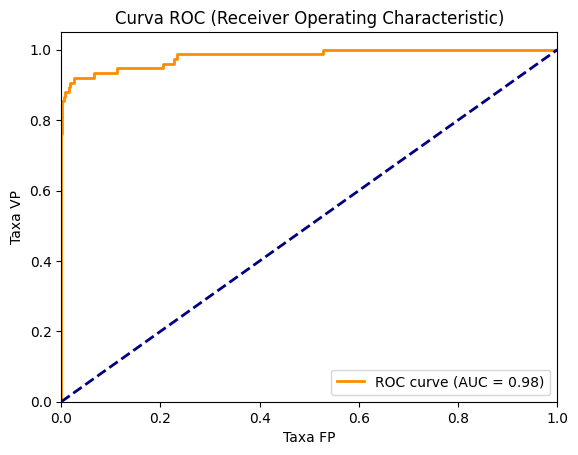

In [13]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_val, probabilidades) # já temos esses valores, portanto não precisamos recalculamos usando o SK-learn

roc_auc = auc(fpr, tpr)
# roc_auc = auc(taxa_FP, taxa_VP)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa FP')
plt.ylabel('Taxa VP')
plt.title('Curva ROC (Receiver Operating Characteristic)')
plt.legend(loc='lower right')
plt.show()

# Parte 2  
Inicialmente, com limiares muito baixos, o modelo detecta praticamente todas as fraudes, mas ao custo de classificar quase todas as transações como fraudulentas. À medida que o limiar aumenta, é possível reduzir significativamente os falsos positivos mantendo uma taxa de detecção de fraudes relativamente estável.
O limiar de 0,30 seria uma escolha mais equilibrada. Neste ponto, o modelo consegue detectar 86,7% das fraudes, ao mesmo tempo em que marca incorretamente apenas 0,64% das transações legítimas como fraudulentas.
A curva ROC, com uma área sob a curva (AUC) de 0,98, corrobora esta escolha, indicando um bom desempenho do modelo. Este valor próximo de 1 sugere que o modelo tem uma capacidade de discriminar entre transações fraudulentas e legítimas.
